In [6]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import os
import xgboost as xgb

#from sklearn.grid_search import GridSearchCV
#from sklearn.metrics import log_loss
#from sklearn.ensemble import RandomForestClassifier
from IPython.display import display

from Util.data_utils import ReadCSV
from Util.Utils import FirstLook

In [152]:
plt.figure(figsize=(15, 8))

In [22]:
Path = "D:\\test\\Kaggle\\Util\\dataset\\Instacart"
aisles, departments, order_products__prior, order_products__train, orders, products, sample_submission = \
ReadCSV("aisles.csv", "departments.csv", "order_products__prior.csv", "order_products__train.csv", \
"orders.csv", "products.csv", "sample_submission.csv", path=Path)

In [40]:
display(aisles.head(5))
print(aisles.shape)
display(departments.head(5))
print(departments.shape)
display(products.head(5))
print(products.shape)

,aisle_id,aisle
0,1,prepared soups salads
1,2,specialty cheeses
2,3,energy granola bars
3,4,instant foods
4,5,marinades meat preparation


(134, 2)


,department_id,department
0,1,frozen
1,2,other
2,3,bakery
3,4,produce
4,5,alcohol


(21, 2)


,product_id,product_name,aisle_id,department_id
0,1,Chocolate Sandwich Cookies,61,19
1,2,All-Seasons Salt,104,13
2,3,Robust Golden Unsweetened Oolong Tea,94,7
3,4,Smart Ones Classic Favorites Mini Rigatoni Wit...,38,1
4,5,Green Chile Anytime Sauce,5,13


(49688, 4)


In [32]:
print(order_products__prior.shape)
display(order_products__prior.head(10))
print(order_products__train.shape)
display(order_products__train.head(10))

(32434489, 4)


,order_id,product_id,add_to_cart_order,reordered
0,2,33120,1,1
1,2,28985,2,1
2,2,9327,3,0
3,2,45918,4,1
4,2,30035,5,0
5,2,17794,6,1
6,2,40141,7,1
7,2,1819,8,1
8,2,43668,9,0
9,3,33754,1,1


(1384617, 4)


,order_id,product_id,add_to_cart_order,reordered
0,1,49302,1,1
1,1,11109,2,1
2,1,10246,3,0
3,1,49683,4,0
4,1,43633,5,1
5,1,13176,6,0
6,1,47209,7,0
7,1,22035,8,1
8,36,39612,1,0
9,36,19660,2,1


In [33]:
print(orders.shape)
display(orders.head(12))

(3421083, 7)


,order_id,user_id,eval_set,order_number,order_dow,order_hour_of_day,days_since_prior_order
0,2539329,1,prior,1,2,8,NaN
1,2398795,1,prior,2,3,7,15.0
2,473747,1,prior,3,3,12,21.0
3,2254736,1,prior,4,4,7,29.0
4,431534,1,prior,5,4,15,28.0
5,3367565,1,prior,6,2,7,19.0
6,550135,1,prior,7,1,9,20.0
7,3108588,1,prior,8,1,14,14.0
8,2295261,1,prior,9,1,16,0.0
9,2550362,1,prior,10,4,8,30.0


What type of products are bought when a user is buying after a month, a week, same day?

In [127]:
def HighestBought(days_since_prior_order):
    periodic_orders = orders[((orders.days_since_prior_order == days_since_prior_order) & (orders.eval_set == 'prior'))]
    periodic_orders = pd.Series(periodic_orders['order_id'].values)
    periodic_products = order_products__prior[order_products__prior['order_id'].isin(periodic_orders)]
    periodic_product_freq =  periodic_products.groupby('product_id')['product_id'].agg({'Product_Frequency':'count'}).reset_index()
    Products_ndays = periodic_product_freq.join(products.set_index('product_id'), on='product_id')
    return Products_ndays.nlargest(10, 'Product_Frequency')

def HighestBoughtAisle(days_since_prior_order, nreturn):
    periodic_orders = orders[((orders.days_since_prior_order == days_since_prior_order) & (orders.eval_set == 'prior'))]
    periodic_orders = pd.Series(periodic_orders['order_id'].values)
    periodic_products = order_products__prior[order_products__prior['order_id'].isin(periodic_orders)]
    periodic_products = periodic_products.join(products.set_index('product_id'), on='product_id')
    periodic_product_freq =  periodic_products.groupby('aisle_id')['aisle_id'].agg({'Aisle_Frequency':'count'}).reset_index()
    sum_frequency = sum(periodic_product_freq.Aisle_Frequency)
    periodic_product_freq.Aisle_Frequency = periodic_product_freq.Aisle_Frequency/sum_frequency
    return periodic_product_freq.nlargest(nreturn, 'Aisle_Frequency')


In [99]:
days_since_prior_order = [30, 7, 0]
for ndays in days_since_prior_order:
    display(str(ndays) + ' days')
    display(HighestBought(ndays))

'30days'

,product_id,Frequency,product_name,aisle_id,department_id
21884,24852,40772,Banana,24,4
11589,13176,28236,Bag of Organic Bananas,24,4
19292,21903,22553,Organic Baby Spinach,123,4
18613,21137,19568,Organic Strawberries,24,4
41508,47209,16545,Organic Hass Avocado,24,4
41869,47626,16167,Large Lemon,24,4
41992,47766,16010,Organic Avocado,24,4
14786,16797,13664,Strawberries,24,4
23067,26209,13447,Limes,24,4
43692,49683,10911,Cucumber Kirby,83,4


'7days'

,product_id,Frequency,product_name,aisle_id,department_id
21234,24852,57691,Banana,24,4
11259,13176,42773,Bag of Organic Bananas,24,4
18047,21137,28640,Organic Strawberries,24,4
18715,21903,26389,Organic Baby Spinach,123,4
40309,47209,23190,Organic Hass Avocado,24,4
40785,47766,19860,Organic Avocado,24,4
40667,47626,17217,Large Lemon,24,4
14355,16797,16316,Strawberries,24,4
23789,27845,15452,Organic Whole Milk,84,16
22390,26209,15268,Limes,24,4


'0days'

,product_id,Frequency,product_name,aisle_id,department_id
14414,24852,5640,Banana,24,4
7591,13176,4689,Bag of Organic Bananas,24,4
12251,21137,3019,Organic Strawberries,24,4
12703,21903,2844,Organic Baby Spinach,123,4
27359,47209,2335,Organic Hass Avocado,24,4
15214,26209,2121,Limes,24,4
27687,47766,1906,Organic Avocado,24,4
9700,16797,1893,Strawberries,24,4
27608,47626,1845,Large Lemon,24,4
16236,27966,1730,Organic Raspberries,123,4


In [128]:
days_since_prior_order = [30, 7, 0]
top_n_return = 30
Aisle_Frequency = pd.DataFrame()

for ndays in days_since_prior_order:
    display(str(ndays) + ' days')
    tmp = HighestBoughtAisle(ndays, top_n_return)
    if Aisle_Frequency.empty:
        Aisle_Frequency = Aisle_Frequency.append(tmp)
    else:
        Aisle_Frequency = Aisle_Frequency.join(tmp.set_index('aisle_id'), lsuffix=str(ndays), on='aisle_id')

'30 days'

'7 days'

'0 days'

In [129]:
Aisle_Frequency = Aisle_Frequency.join(aisles.set_index('aisle_id'), on='aisle_id')

In [130]:
display(Aisle_Frequency.head())
Aisle_Frequency.shape

,aisle_id,Aisle_Frequency7,Aisle_Frequency0,Aisle_Frequency,aisle
82,83,0.105620,0.103942,0.098835,fresh vegetables
23,24,0.097210,0.122484,0.108006,fresh fruits
122,123,0.051928,0.055377,0.050288,packaged vegetables fruits
119,120,0.040950,0.050097,0.041460,yogurt
20,21,0.031452,0.030171,0.025833,packaged cheese


(30, 5)

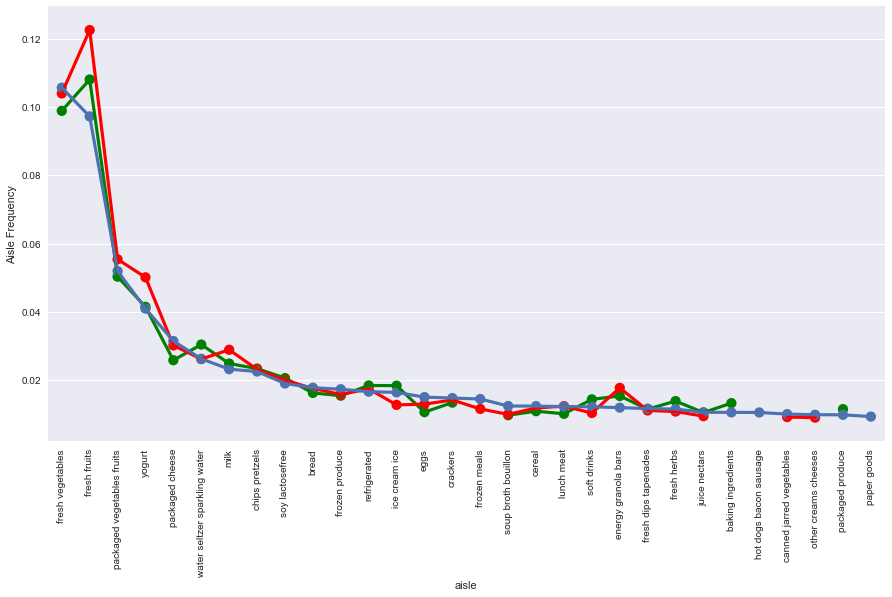

In [154]:
plt.figure(figsize=(15, 8))
sns.pointplot(x='aisle', y='Aisle_Frequency', data=Aisle_Frequency, color='g')
sns.pointplot(x='aisle', y='Aisle_Frequency0', data=Aisle_Frequency, color='r')
sns.pointplot(x='aisle', y='Aisle_Frequency7', data=Aisle_Frequency)
plt.xticks(rotation=90)
plt.ylabel('Aisle Frequency')
plt.show()

In [161]:
#Aisle_Frequency.head()
print('correlation between Aisle_Frequency7 and Aisle_Frequency0', )
display(Aisle_Frequency['Aisle_Frequency7'].corr(Aisle_Frequency['Aisle_Frequency0']))
print('correlation between Aisle_Frequency7 and Aisle_Frequency30', )
display(Aisle_Frequency['Aisle_Frequency7'].corr(Aisle_Frequency['Aisle_Frequency']))
print('correlation between Aisle_Frequency0 and Aisle_Frequency30', )
display(Aisle_Frequency['Aisle_Frequency'].corr(Aisle_Frequency['Aisle_Frequency0']))

correlation between Aisle_Frequency7 and Aisle_Frequency0


0.98645097091549427

correlation between Aisle_Frequency7 and Aisle_Frequency30


0.99038474418415268

correlation between Aisle_Frequency0 and Aisle_Frequency30


0.99443792468559966

In [163]:
display(order_products__prior[order_products__prior.order_id==3108588])
display(order_products__prior[order_products__prior.order_id==2295261])
display(order_products__train[order_products__train.order_id==1187899])

,order_id,product_id,add_to_cart_order,reordered
29474805,3108588,12427,1,1
29474806,3108588,196,2,1
29474807,3108588,10258,3,1
29474808,3108588,25133,4,1
29474809,3108588,46149,5,0
29474810,3108588,49235,6,0


,order_id,product_id,add_to_cart_order,reordered
21760443,2295261,49235,1,1
21760444,2295261,46149,2,1
21760445,2295261,25133,3,1
21760446,2295261,196,4,1
21760447,2295261,10258,5,1
21760448,2295261,12427,6,1


,order_id,product_id,add_to_cart_order,reordered
484420,1187899,196,1,1
484421,1187899,25133,2,1
484422,1187899,38928,3,1
484423,1187899,26405,4,1
484424,1187899,39657,5,1
484425,1187899,10258,6,1
484426,1187899,13032,7,1
484427,1187899,26088,8,1
484428,1187899,27845,9,0
484429,1187899,49235,10,1


In [168]:
display(order_products__prior[order_products__prior.order_id==550135])
display(order_products__prior[order_products__prior.order_id==3108588])
display(order_products__prior[order_products__prior.order_id==2550362])
display(order_products__train[order_products__train.order_id==1187899])
display(order_products__prior[order_products__prior.order_id==2254736])

,order_id,product_id,add_to_cart_order,reordered
5212927,550135,196,1,1
5212928,550135,10258,2,1
5212929,550135,12427,3,1
5212930,550135,25133,4,1
5212931,550135,13032,5,1


,order_id,product_id,add_to_cart_order,reordered
29474805,3108588,12427,1,1
29474806,3108588,196,2,1
29474807,3108588,10258,3,1
29474808,3108588,25133,4,1
29474809,3108588,46149,5,0
29474810,3108588,49235,6,0


,order_id,product_id,add_to_cart_order,reordered
24181266,2550362,196,1,1
24181267,2550362,46149,2,1
24181268,2550362,39657,3,0
24181269,2550362,38928,4,0
24181270,2550362,25133,5,1
24181271,2550362,10258,6,1
24181272,2550362,35951,7,0
24181273,2550362,13032,8,1
24181274,2550362,12427,9,1


,order_id,product_id,add_to_cart_order,reordered
484420,1187899,196,1,1
484421,1187899,25133,2,1
484422,1187899,38928,3,1
484423,1187899,26405,4,1
484424,1187899,39657,5,1
484425,1187899,10258,6,1
484426,1187899,13032,7,1
484427,1187899,26088,8,1
484428,1187899,27845,9,0
484429,1187899,49235,10,1


,order_id,product_id,add_to_cart_order,reordered
21376074,2254736,196,1,1
21376075,2254736,12427,2,1
21376076,2254736,10258,3,1
21376077,2254736,25133,4,1
21376078,2254736,26405,5,1


In [165]:
orders[orders.eval_set=='test']

,order_id,user_id,eval_set,order_number,order_dow,order_hour_of_day,days_since_prior_order
38,2774568,3,test,13,5,15,11.0
44,329954,4,test,6,3,12,30.0
53,1528013,6,test,4,3,16,22.0
96,1376945,11,test,8,6,11,8.0
102,1356845,12,test,6,1,20,30.0
152,2161313,15,test,23,1,9,7.0
159,1416320,16,test,7,0,13,7.0
217,1735923,19,test,10,6,17,8.0
222,1980631,20,test,5,1,11,30.0
272,139655,22,test,16,5,6,1.0
